# BCS file generation

## Main BCS file function

In [3]:
from random import random
import numpy as np
import sys
from math import floor
np.set_printoptions(threshold=sys.maxsize)

def bcs_gen(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, fire_rates, resolution):

    file_name = cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max)
    
    bcfile = 'code/DNAReplication.bc'
    new_bcfile = r'code/bcs_scripts/DNAReplication_'+cell_line+'_chr['+str(chr_number)+']_'+str(chrpos_min)+'-'+str(chrpos_max) + '.bc'
    bcsfile = []
    
    chrLength = chrpos_max - chrpos_min
    orign = int(chrLength * resolution / 1000)
    fast = 100000
    x = np.linspace(chrpos_min, chrpos_max, chrLength)  # Chromosome positions
    
    with open(bcfile, 'r') as file:
        bcsfile = file.readlines()
    bcsfile[bcsfile.index("// Chromosome length\n")+1] = "L = "+str(chrLength)+";\n"
    bcsfile[bcsfile.index("// Fast rate\n")+1] = "fast = "+str(fast)+";\n"
    bcsfile[bcsfile.index("// Fork velocity\n")+1] = "v = "+str(fork_speed)+";\n"
    
    oril = list(map(floor, np.linspace(1, chrLength, num=orign)))
    
    flistn = fire_rates
    
    # write new origins
    oriarr = np.array([
        'ORI[' + str(floor(oril[i1])) + ',' + '{:.30f}'.format(flistn[i1]) + ']'
        for i1 in range(0, orign)
    ])
    
    # delete all the origins
    with open(new_bcfile, 'w') as fp:
        for number, line in enumerate(bcsfile):
            if number not in range(bcsfile.index("// PROCESS INITIATION\n")+1, bcsfile.index("// END")-2):
                fp.write(line)
        
    # now change the last line
    with open(new_bcfile, 'r') as file:
        bcsfile = file.readlines()
        bcsfile[bcsfile.index("// PROCESS INITIATION\n")+1] = str(oriarr).replace('"','').replace("'",'').replace(" "," || ")[1:-1]+';\n'
    
    with open(new_bcfile, 'w') as file:
        file.writelines(bcsfile)

## BCS file generation

In [125]:
# Skip if data/bcs_scripts files already exist
# These should be run using Beacon Calculus. HPC recommended.
# Single files #
sing_filesQ = False
if sing_filesQ:

    cell_line = "HeLa-S3"
    chr_number = 1
    chrpos_min = 3000
    chrpos_max = 3200
    fork_speed = 1.4
    resolution = 1000 # (1 kb)
    fire_rates = np.loadtxt('data/whole-genome_firing_rates/fire_rates_' + cell_line + '_chr[' + str(chr_number) + '].txt', dtype='float64')[chrpos_min:chrpos_max]
    
    bcs_gen(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, fire_rates, resolution)

# Multiple bcs generation (long computation) #
mult_fileQ = False
if mult_fileQ:
    
    cell_lines = ["HeLa-S3","BJ1","IMR90","HUVEC","K562","GM12878","HepG2","MCF-7"]
    chr_range = range(1,23)
    fork_speed = 1.4
    resolution = 1000
    
    for cell_line_i in cell_lines:
        
        for chr_number_i in chr_range:
            
            fire_rates = np.loadtxt('data/whole-genome_firing_rates/fire_rates_' + cell_line_i + '_chr[' + str(chr_number_i) + '].txt', dtype='float64')
            int_step = 10000 # sets the number of bcs simulation points
            partition_intervals = [[i, min(i + int_step, len(fire_rates))] for i in range(0, len(fire_rates), int_step)]
            
            for partition_intervals_i in partition_intervals:
                
                bcs_gen(cell_line_i, chr_number_i, partition_intervals_i[0], partition_intervals_i[1], fork_speed, fire_rates[partition_intervals_i[0]:partition_intervals_i[1]], resolution)

# BCS simulation output

## Replication timing, fork directionality and origins

In [18]:
import numpy as np
import os

def process_bcs_output(cell_line, chr_number, chrpos_min, chrpos_max, fork_speed, resolution, scale_factor, sim_number, compute_replication_time, compute_fork_directionality, compute_origin_positions):
    # Define the file path
    file_path = f'data/bcs_output/bcs_output_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.simulation.bcs'

    # Initialize arrays to store replication time and fork directionality
    DNA_replicationtime = [0.0 for _ in range(0, chrpos_max - chrpos_min)] if compute_replication_time else None
    DNA_forkdirectionality = [0.0 for _ in range(0, chrpos_max - chrpos_min)] if compute_fork_directionality else None
    DNA_originpositions = [] if compute_origin_positions else None  # List to store origin positions per simulation
    current_origins = []
    sim_iteration = 0

    with open(file_path) as f:
        for line in f:
            if sim_iteration == sim_number + 1:
                break
            if line[0] == '>':
                alreadyDone = []
                if compute_origin_positions and current_origins:  # If we have collected origins for the current simulation
                    DNA_originpositions.append(current_origins)
                current_origins = []
                print(sim_iteration, end="\r")
                sim_iteration += 1
                continue
            splitLine = line.split('\t')
            if compute_origin_positions and splitLine[2] == "ORI":
                origin_pos = int(splitLine[4])
                current_origins.append(origin_pos)
            if splitLine[2] == "FL":
                pos = int(splitLine[4]) - 1
                time = float(splitLine[0])
                if pos not in alreadyDone:
                    if compute_replication_time:
                        DNA_replicationtime[pos] += time
                    if compute_fork_directionality:
                        DNA_forkdirectionality[pos] -= 1  # Track left-moving forks
                    alreadyDone.append(pos)
            if splitLine[2] == "FR":
                pos = int(splitLine[4]) - 1
                time = float(splitLine[0])
                if pos not in alreadyDone:
                    if compute_replication_time:
                        DNA_replicationtime[pos] += time
                    if compute_fork_directionality:
                        DNA_forkdirectionality[pos] += 1  # Track right-moving forks
                    alreadyDone.append(pos)

    # Don't forget to add the origins of the last simulation
    if compute_origin_positions and current_origins:
        DNA_originpositions.append(current_origins)

    # Average the results over the number of simulations
    if compute_replication_time:
        for i in range(len(DNA_replicationtime)):
            DNA_replicationtime[i] = float(DNA_replicationtime[i]) / float(sim_number)

    if compute_fork_directionality:
        for i in range(len(DNA_forkdirectionality)):
            DNA_forkdirectionality[i] = float(DNA_forkdirectionality[i]) / float(sim_number)

    # Define file paths for saving the results
    base_path = 'data'
    replication_time_path = os.path.join(base_path, 'whole-genome_timing_bcs', f'replication_time_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    fork_directionality_path = os.path.join(base_path, 'whole-genome_fork_directionality', f'fork_directionality_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    origin_positions_path = os.path.join(base_path, 'whole-genome_origins', f'origin_positions_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')

    # Create directories if they do not exist
    os.makedirs(os.path.dirname(replication_time_path), exist_ok=True)
    os.makedirs(os.path.dirname(fork_directionality_path), exist_ok=True)
    os.makedirs(os.path.dirname(origin_positions_path), exist_ok=True)

    # Save the results to text files
    if compute_replication_time:
        np.savetxt(replication_time_path, DNA_replicationtime, fmt='%.6f')

    if compute_fork_directionality:
        np.savetxt(fork_directionality_path, DNA_forkdirectionality, fmt='%.6f')

    if compute_origin_positions:
        with open(origin_positions_path, 'w') as f:
            for origins in DNA_originpositions:
                f.write(' '.join(map(str, origins)) + '\n')

## Interorigin distances

In [19]:
import numpy as np
import os

def compute_interorigin_distances(cell_line, chr_number, chrpos_min, chrpos_max):
    base_path = 'data'
    
    # Define file path for loading the origins
    origins_path = os.path.join(base_path, 'whole-genome_origins', f'origin_positions_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    
    # Load origins data from text file
    if os.path.exists(origins_path):
        with open(origins_path, 'r') as f:
            origins_data = [list(map(int, line.strip().strip('[]').split())) for line in f]
    else:
        raise FileNotFoundError(f"Origins data not found at {origins_path}")
    
    # Compute interorigin distances for each simulation
    interorigin_distances = []
    for origins in origins_data:
        origins_sorted = sorted(origins)
        distances = np.diff(origins_sorted)
        interorigin_distances.append(distances)
    
    # Define file path for saving the interorigin distances
    iod_path = os.path.join(base_path, 'whole-genome_interorigin_distances', f'iod_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    
    # Save interorigin distances to a text file
    with open(iod_path, 'w') as f:
        for distances in interorigin_distances:
            f.write(f"{list(distances)}\n")

## Example: bcs output data generation

In [54]:
chr_lengths = [249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365, 141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355, 81196, 78078, 59129, 63026, 48130, 51305]

def process_intervals(cell_lines, chr_numbers, fork_speed=1.4, resolution=1000, scale_factor=5, sim_number=5, compute_replication_time=True, compute_fork_directionality=True, compute_origin_positions=True, interval=None):
    for cell_line in cell_lines:
        for chr_number in chr_numbers:
            chr_length = chr_lengths[chr_number - 1]  # Get the length of the chromosome
            intervals = [(interval[0], interval[1])] if interval else [(start, min(start + 10000, chr_length)) for start in range(0, chr_length, 10000)]
            for start, end in intervals:
                process_bcs_output(
                    cell_line=cell_line,
                    chr_number=chr_number,
                    chrpos_min=start,
                    chrpos_max=end,
                    fork_speed=fork_speed,
                    resolution=resolution,
                    scale_factor=scale_factor,
                    sim_number=sim_number,
                    compute_replication_time=compute_replication_time,
                    compute_fork_directionality=compute_fork_directionality,
                    compute_origin_positions=compute_origin_positions
                )

def compute_interorigin_intervals(cell_lines, chr_numbers, interval=None):
    for cell_line in cell_lines:
        for chr_number in chr_numbers:
            chr_length = chr_lengths[chr_number - 1]  # Get the length of the chromosome
            intervals = [(interval[0], interval[1])] if interval else [(start, min(start + 10000, chr_length)) for start in range(0, chr_length, 10000)]
            for start, end in intervals:
                compute_interorigin_distances(
                    cell_line=cell_line,
                    chr_number=chr_number,
                    chrpos_min=start,
                    chrpos_max=end
                )

# Example usage
cell_lines = ["HeLa-S3"]  #, "BJ1", "IMR90"] #, "HUVEC", "K562", "GM12878", "HepG2", "MCF-7"]
chr_numbers = [1]  #, 2, 3]
interval = (10000, 20000)  # Specify interval here

process_intervals(cell_lines, chr_numbers, sim_number=500,interval=interval)
compute_interorigin_intervals(cell_lines, chr_numbers, interval=interval)


# Plots

## Simulated time and fork directionality

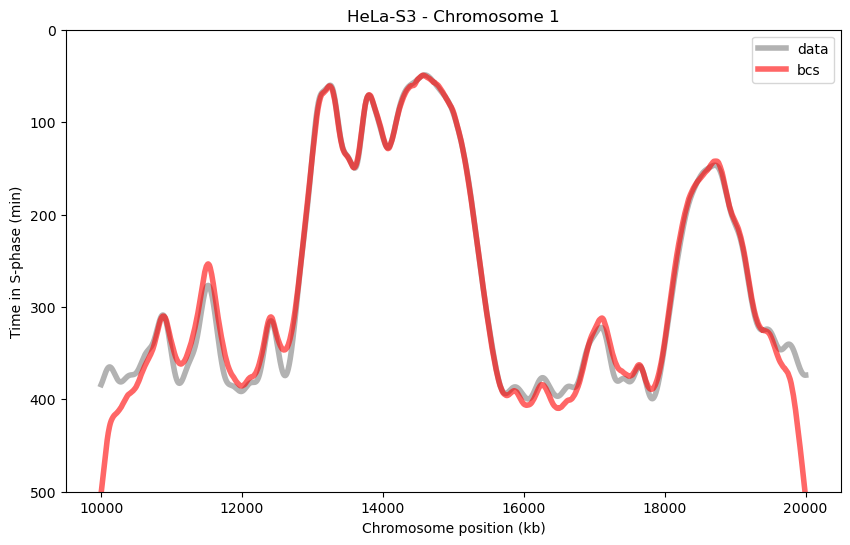

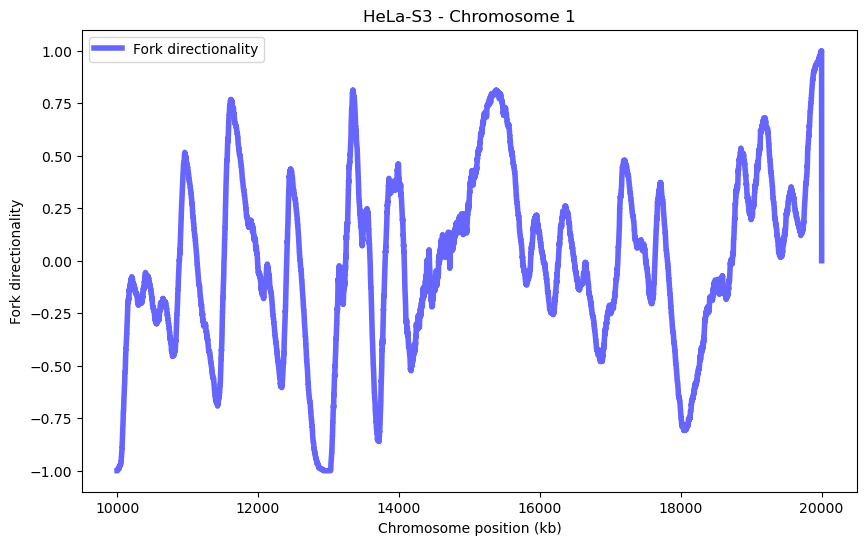

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_replication_data(cell_line, chr_number, chrpos_min, chrpos_max, saveQ=False, file_name='replication_data'):
    base_path = 'data'

    # Define file paths for loading the results
    replication_time_path = os.path.join(base_path, 'whole-genome_timing_bcs', f'replication_time_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    fork_directionality_path = os.path.join(base_path, 'whole-genome_fork_directionality', f'fork_directionality_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    real_timing_data_path = os.path.join(base_path, 'whole-genome_timing_data', f'time_data_{cell_line}_chr[{chr_number}].txt')

    # Load data from text files
    if os.path.exists(replication_time_path):
        DNA_replicationtime = np.loadtxt(replication_time_path, dtype=float)
    else:
        raise FileNotFoundError(f"Replication time data not found at {replication_time_path}")

    if os.path.exists(fork_directionality_path):
        DNA_forkdirectionality = np.loadtxt(fork_directionality_path, dtype=float)
    else:
        raise FileNotFoundError(f"Fork directionality data not found at {fork_directionality_path}")

    if os.path.exists(real_timing_data_path):
        real_timing_data = np.loadtxt(real_timing_data_path, dtype=float)[chrpos_min:chrpos_max]
    else:
        raise FileNotFoundError(f"Real timing data not found at {real_timing_data_path}")

    # Generate chromosome positions
    x = np.linspace(chrpos_min, chrpos_max, chrpos_max - chrpos_min)

    # Plot replication time
    plt.figure(figsize=(10, 6))
    plt.plot(x, real_timing_data, label='data', color='gray', linewidth=4, alpha=0.6)
    plt.plot(x, DNA_replicationtime, label='bcs', color='red', linewidth=4, alpha=0.6)
    plt.title(f'{cell_line} - Chromosome {chr_number}')
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Time in S-phase (min)')
    plt.ylim(500, 0)
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.grid(False)
    ax.tick_params(axis='both', which='both', direction='out')
    for spine in ax.spines.values():
        spine.set_visible(True)

    if saveQ:
        plt.savefig(f'figures/plot_RT_{file_name}_replication_time.svg', bbox_inches='tight', transparent=True)

    plt.show()

    # Plot fork directionality
    plt.figure(figsize=(10, 6))
    plt.plot(x, DNA_forkdirectionality, label='Fork directionality', color='blue', linewidth=4, alpha=0.6)
    plt.title(f'{cell_line} - Chromosome {chr_number}')
    plt.xlabel('Chromosome position (kb)')
    plt.ylabel('Fork directionality')
    plt.legend()
    plt.grid(True)

    ax = plt.gca()
    ax.grid(False)
    ax.tick_params(axis='both', which='both', direction='out')
    for spine in ax.spines.values():
        spine.set_visible(True)

    if saveQ:
        plt.savefig(f'figures/plot_RT_{file_name}_fork_directionality.svg', bbox_inches='tight', transparent=True)

    plt.show()

# Example usage
plot_replication_data(
    cell_line='HeLa-S3',
    chr_number=1,
    chrpos_min=10000,
    chrpos_max=20000,
    saveQ=True,
    file_name='example'
)


## Interorigin distance distribution

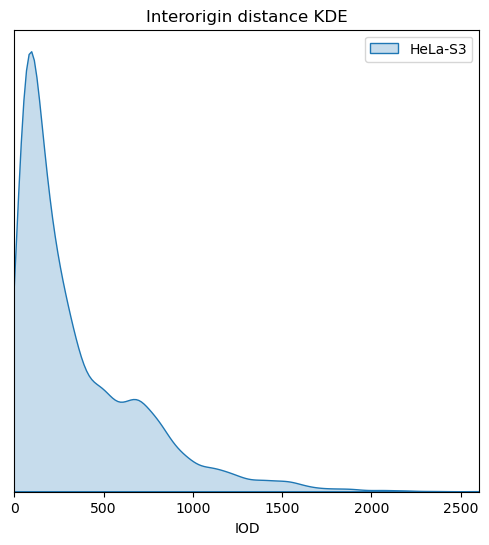

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_relative_kdes(data_list, labels, bw_adjust=1, x_grid_size=1000, log_scale=False, x_min=None, x_max=None, plot_title="Relative density plots", x_title="Error", save_name="savedfile"):
    data_list = [np.array(data) for data in data_list]  # Ensure all elements are numpy arrays
    if log_scale:
        # Filter out non-positive values for log scale
        data_list = [data[data > 0] for data in data_list]
        if x_min is None:
            x_min = min(data.min() for data in data_list)
        if x_max is None:
            x_max = max(data.max() for data in data_list)
        x = np.logspace(np.log10(x_min), np.log10(x_max), x_grid_size)
    else:
        if x_min is None:
            x_min = min(data.min() for data in data_list)
        if x_max is None:
            x_max = max(data.max() for data in data_list)
        x = np.linspace(x_min, x_max, x_grid_size)

    plt.figure(figsize=(6, 6))

    # Compute and plot the KDEs
    for data, label in zip(data_list, labels):
        sns.kdeplot(data, fill=True, bw_adjust=bw_adjust, label=label)

    plt.title(plot_title)
    plt.xlabel(x_title)
    
    plt.gca().yaxis.set_visible(False)  # Remove y-axis ticks
    plt.ylabel('')  # Remove y-axis label

    if log_scale:
        plt.xscale('log')
        exponent_jump = 2  # default value, you can adjust this parameter as needed
        plt.xticks(
            ticks=np.logspace(
                np.floor(np.log10(x_min)), 
                np.ceil(np.log10(x_max)), 
                num=int((np.ceil(np.log10(x_max)) - np.floor(np.log10(x_min))) / exponent_jump) + 1
            ), 
            labels=[
                f'$10^{{{int(i)}}}$' for i in np.arange(
                    np.floor(np.log10(x_min)), 
                    np.ceil(np.log10(x_max)) + 1, 
                    exponent_jump
                )
            ]
        )

    plt.xlim(0, x_max)
    plt.legend()
    plt.savefig(f'figures/fig_kdeplot_{save_name}.svg', bbox_inches='tight', transparent=True)
    plt.show()

def load_iod_data(cell_line, chr_number, chrpos_min, chrpos_max, base_path='data/whole-genome_interorigin_distances', factor=50):
    file_path = os.path.join(base_path, f'iod_{cell_line}_chr[{chr_number}]_{chrpos_min}-{chrpos_max}.txt')
    iod_data = []
    with open(file_path, 'r') as file:
        for line in file:
            iod_values = list(map(float, line.strip().strip('[]').split(',')))
            iod_data.extend([iod for iod in iod_values if iod >= factor])  # Filter IOD values
    return np.array(iod_data)

def average_iod_data(cell_lines, chr_numbers, chr_lengths, base_path='data/whole-genome_interorigin_distances', show_per_cell_line=False, factor=3):
    all_iod_data = []
    iod_data_per_cell_line = []

    for cell_line in cell_lines:
        cell_line_iod_data = []
        for chr_number in chr_numbers:
            chr_length = chr_lengths[chr_number - 1]
            for start in range(0, chr_length, 10000):
                end = min(start + 10000, chr_length)
                iod_data = load_iod_data(cell_line, chr_number, start, end, base_path, factor)
                cell_line_iod_data.extend(iod_data)
        iod_data_per_cell_line.append(cell_line_iod_data)
        all_iod_data.extend(cell_line_iod_data)

    if show_per_cell_line:
        return iod_data_per_cell_line, cell_lines
    else:
        return [all_iod_data], ["All Cell Lines"]

def plot_iod_kde(cell_lines, chr_numbers, chr_lengths, base_path='data/whole-genome_interorigin_distances', show_per_cell_line=False, bw_adjust=1, x_grid_size=1000, log_scale=False, x_min=None, x_max=None, plot_title="IOD KDE Plot", x_title="IOD", save_name="iod_kde_plot", factor=2):
    data, labels = average_iod_data(cell_lines, chr_numbers, chr_lengths, base_path, show_per_cell_line, factor)
    plot_relative_kdes(data, labels, bw_adjust, x_grid_size, log_scale, x_min, x_max, plot_title, x_title, save_name)

# Example usage
cell_lines = ["HeLa-S3"]#, "BJ1", "IMR90"]
chr_numbers = [1]
chr_lengths = [249251, 243200, 198023, 191155, 180916, 171116, 159139, 146365, 141214, 135535, 135007, 133852, 115170, 107350, 102532, 90355, 81196, 78078, 59129, 63026, 48130, 51305]
plot_iod_kde(cell_lines, chr_numbers, chr_lengths, show_per_cell_line=True, log_scale=False, plot_title="Interorigin distance KDE", save_name="iod_kde", factor=2)
